In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'natural-adversarial-examples-imageneta:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F280740%2F579959%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240605%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240605T215719Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5f1c23c956dfeeec9b5fa6fed6b4f682b2f660d5876c844d02f8ca1d65c663d7306eeb89dcd840c10a8352fd45f912ca83ac4d462f3b7b5e5d0c6427f6f080d8381794fefc9a00a3ecc82bbec8ce67fc4db8b1e980bf8054f0cc51c3de7d3557ec2cc0f6cd9c87976024af162612a67d8df614c51ee3219b77f1f585ea7e7f78f239173fb6e442af03945244b8a945b2b74ad32d42d7b3516f73cc8820b06216420fee004fed85577257d2e68eced2fdb074146b6536ebb02219293a75eb1f2953c5510eb1b674b3c398ec87e176667301f3d94d94a1fa1a71d09bc7a23e8150bf305cc0825f94657aaa29a0068e32f9d6924784a71ff759b517ba791a0681af,imagenet-classes:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F406353%2F779014%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240605%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240605T215719Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da2cddad42ebbe184325c2c6459c813b2bf6afa50e7b9e03f30400bbdd9b54cc38f15c951d5d43a1c7a966393c3dea77661dfe5a82256c139944a93b34302f568c594ec16fddbce14a368e8dd0cdc70fc594a203d7aa87e2b0806397d8e28be667571944cab8e2fa32d31f4e69c554656f04d6e227179417604112b7e5b4c75864818157a67125780dea000812c30855c375e7cd4832c76d7742627c2c2219b87883c3dd267a1ee42fd81d6f348e0fe794c16dc5d8c738e7613c474ae7261d79cbf5dbe3e12415e34a1fe88166369c07ea5cf3c3f2a41fbffaebf5a1a750e627fba47e506d8f34e44af621bcfd73648b2fa203e8b3691d3643c46cf7d82aa1186'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 699505689 bytes downloaded
Downloaded and uncompressed: natural-adversarial-examples-imageneta
[==================================================] 13128 bytes downloaded
Downloaded and uncompressed: imagenet-classes
Data source import complete.


# Deep Learning Project Report
### by Kemal Alp Sezer and Ibrahim Khalil Mejri



## Overview

In this project we have applied MEMO, a Test Time Adaptation (TTA) method on the CLIP model to enhance the classification accuracy of the base model. To apply this TTA method, we assume access to a pretrained CLIP model, a single test sample and an augmentation function applied to the test sample. For the test samples, we use the ImageNet-A dataset which is known for the hard to classify adverserial images and we test the base CLIP model on this dataset together the tuned version which uses MEMO to see if the accuracy improves. We experiment with different augmentation functions to see if it will lead to any improvements and we test different confidence selection strategies to filter the augmented images.

In [5]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-o4_yf4mh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-o4_yf4mh
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


#### Importing necessary Libraries:

In [6]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as trn
import torchvision.transforms.functional as trnF
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import os
import fastprogress
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageOps, Image


import clip
from PIL import Image
import json
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Choosing device (CPU or cuda:0) and setting a seed for reproducibility:

In [7]:
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and
        cuda is available on your system, returns a cuda device.

    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device

    Returns: pytorch device object
            Pytorch device
    """

    print('cuda available:', torch.cuda.is_available(),
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())

    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device


device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')



#function for setting seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)

cuda available: False ; cudnn available: True ; num devices: 0
Using device cpu
2 CPUs available


## THE CLIP MODEL

CLIP (Contrastive Language-Image Pretraining) model is developed by OpenAI and is designed to understand text, images, and their relationships. It provides a joint latent space for text and images linking the two modalities semantically. It can connect images with textual descriptions without requiring labeled datasets, making it highly adaptable to various tasks with zero-shot learning capabilities.

### Architecture
CLIP consists of two encoders which are trained jointly to produce embeddings of text and images that lie in the same high-dimensional space, allowing direct comparison.

- Text Encoder: Usually based on the Transformer architecture (like GPT or BERT models), it encodes text descriptions into fixed-size embeddings.
- Image Encoder: Based on a Convolutional Neural Network (CNN) like ResNet or Vision Transformer (ViT), it encodes images into fixed-size embeddings.
- Using the pretrained CLIP model, we are able to choose between a set of vision encoder architectures:
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

- To be consistent with the project description, we chose to work with the ViT-B/16 architecture. This architecture suggests a model variant that combines a Vision Transformer (ViT) for image processing with a Transformer-based text encoder.


Vision Transformer (ViT-B/16) for Image Processing:

![image.png](attachment:45bfbf1a-85c9-4c08-a264-bc2ca26811f3.png)

1.	Image Input: The image is divided into a grid of fixed-size patches, typically 16x16 pixels (the "16" in ViT-B 16).
2.	Linear Embedding: Each patch is flattened and projected into a higher-dimensional space using a linear embedding.
3.	Position Embeddings: Positional information is added to the patch embeddings to retain spatial information.
4.	Transformer Encoder: A series of transformer layers process these embedded patches. The transformer layers include multi-head self-attention mechanisms and feed-forward neural networks.
5.	Output: The final output from the transformer encoder represents the image in a high-dimensional space.

Transformer-based Text Encoder:
1.	Text Input: The text is tokenized into words or subwords.
2.	Embedding: Each token is converted into a dense vector using an embedding layer.
3.	Position Embeddings: Positional encodings are added to the token embeddings to incorporate the order of words.
4.	Transformer Encoder: Similar to the vision part, a series of transformer layers process the text embeddings. These layers include multi-head self-attention mechanisms and feed-forward neural networks.
5.	Output: The final output is a high-dimensional representation of the text.
Contrastive Learning Objective:
1.	Image-Text Pairing: During training, each image is paired with a corresponding text description. These pairs are considered positive pairs.
2.	Embedding: Both the image and the text are encoded into high-dimensional vectors (embeddings) using separate encoders (a Vision Transformer for images and a Transformer for text).
3.	Similarity Measurement: The similarity between the image and text embeddings is calculated, typically using cosine similarity.
4.	Contrastive Loss: A contrastive loss function, such as the InfoNCE loss, is used. This loss function encourages the model to increase the similarity for positive pairs and decrease it for negative pairs (incorrect image-text pairs).



### Areas of Application

Image Classification: CLIP can classify images into categories described by text labels.
Image Search and Retrieval: Given a textual description, CLIP can retrieve the most relevant images from a database.
Text-to-Image Generation: Although CLIP itself is not a generative model, it can guide image generation models like DALL-E by providing a way to measure the similarity between text and generated images.

### Using CLIP as a classifier
In this project, we use the pretrained CLIP model as our image classifier with the task of classifying a given image as one of the IMAGENET classes. To do so we use the text encoder on the classes and get the latent space representation and also encode our single test image, after normalizing the encoded image and text vectors we calculate the similarity between the image and each class of the imagenet dataset using cosine similarity and match the image with the highest scoring class (highest cosine similarity).


In [8]:
#choosing vision encoder ViT-B/16 and loading the pretrained network with preprocessing
print(clip.available_models())
model, preprocess = clip.load("ViT-B/16")
model.to(device).eval()

#Attributes of the model
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("preprocess:", preprocess)

print(model.dtype)
model.to(torch.float32)
print(model.dtype)
torch.save(model.state_dict(), "initial_model_state.pth")

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


100%|███████████████████████████████████████| 335M/335M [00:06<00:00, 57.2MiB/s]


Model parameters: 149,620,737
Input resolution: 224
Context length: 77
Vocab size: 49408
preprocess: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7cae362afbe0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
torch.float32
torch.float32


### Preparing the text labels

Since we are planing to use the ImageNet-A dataset which consists of 200 subset classes of the 1000 ImageNet classes we encode the 200 text labels after tokenizing them in the form "This is a photo of a {corresponding label}" for each label and then normalizing them. We are doing this earlier since the labels are fixed and we wont change the weights of the text encoder. You can see the full list of Imagenet-A labels below

In [9]:
#extracting labels of the imagenet classes

with open('/kaggle/input/imagenet-classes/imagenet1000_clsidx_to_labels.txt', "r") as file:
    json_str = file.read().splitlines()

labels_1000 = list(map(lambda x: x.split("\'")[1].split(",")[0], json_str))

#choosing the 200 imagenet A classes amongst the full 1000 using the dictionary given by the imagenet-A authors
thousand_k_to_200 = {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: 1, 12: -1, 13: 2, 14: -1, 15: 3, 16: -1, 17: 4, 18: -1, 19: -1, 20: -1, 21: -1, 22: 5, 23: 6, 24: -1, 25: -1, 26: -1, 27: 7, 28: -1, 29: -1, 30: 8, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: 9, 38: -1, 39: 10, 40: -1, 41: -1, 42: 11, 43: -1, 44: -1, 45: -1, 46: -1, 47: 12, 48: -1, 49: -1, 50: 13, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: 14, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 15, 71: 16, 72: -1, 73: -1, 74: -1, 75: -1, 76: 17, 77: -1, 78: -1, 79: 18, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: 19, 90: 20, 91: -1, 92: -1, 93: -1, 94: 21, 95: -1, 96: 22, 97: 23, 98: -1, 99: 24, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: 25, 106: -1, 107: 26, 108: 27, 109: -1, 110: 28, 111: -1, 112: -1, 113: 29, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: 30, 125: 31, 126: -1, 127: -1, 128: -1, 129: -1, 130: 32, 131: -1, 132: 33, 133: -1, 134: -1, 135: -1, 136: -1, 137: -1, 138: -1, 139: -1, 140: -1, 141: -1, 142: -1, 143: 34, 144: 35, 145: -1, 146: -1, 147: -1, 148: -1, 149: -1, 150: 36, 151: 37, 152: -1, 153: -1, 154: -1, 155: -1, 156: -1, 157: -1, 158: -1, 159: -1, 160: -1, 161: -1, 162: -1, 163: -1, 164: -1, 165: -1, 166: -1, 167: -1, 168: -1, 169: -1, 170: -1, 171: -1, 172: -1, 173: -1, 174: -1, 175: -1, 176: -1, 177: -1, 178: -1, 179: -1, 180: -1, 181: -1, 182: -1, 183: -1, 184: -1, 185: -1, 186: -1, 187: -1, 188: -1, 189: -1, 190: -1, 191: -1, 192: -1, 193: -1, 194: -1, 195: -1, 196: -1, 197: -1, 198: -1, 199: -1, 200: -1, 201: -1, 202: -1, 203: -1, 204: -1, 205: -1, 206: -1, 207: 38, 208: -1, 209: -1, 210: -1, 211: -1, 212: -1, 213: -1, 214: -1, 215: -1, 216: -1, 217: -1, 218: -1, 219: -1, 220: -1, 221: -1, 222: -1, 223: -1, 224: -1, 225: -1, 226: -1, 227: -1, 228: -1, 229: -1, 230: -1, 231: -1, 232: -1, 233: -1, 234: 39, 235: 40, 236: -1, 237: -1, 238: -1, 239: -1, 240: -1, 241: -1, 242: -1, 243: -1, 244: -1, 245: -1, 246: -1, 247: -1, 248: -1, 249: -1, 250: -1, 251: -1, 252: -1, 253: -1, 254: 41, 255: -1, 256: -1, 257: -1, 258: -1, 259: -1, 260: -1, 261: -1, 262: -1, 263: -1, 264: -1, 265: -1, 266: -1, 267: -1, 268: -1, 269: -1, 270: -1, 271: -1, 272: -1, 273: -1, 274: -1, 275: -1, 276: -1, 277: 42, 278: -1, 279: -1, 280: -1, 281: -1, 282: -1, 283: 43, 284: -1, 285: -1, 286: -1, 287: 44, 288: -1, 289: -1, 290: -1, 291: 45, 292: -1, 293: -1, 294: -1, 295: 46, 296: -1, 297: -1, 298: 47, 299: -1, 300: -1, 301: 48, 302: -1, 303: -1, 304: -1, 305: -1, 306: 49, 307: 50, 308: 51, 309: 52, 310: 53, 311: 54, 312: -1, 313: 55, 314: 56, 315: 57, 316: -1, 317: 58, 318: -1, 319: 59, 320: -1, 321: -1, 322: -1, 323: 60, 324: 61, 325: -1, 326: 62, 327: 63, 328: -1, 329: -1, 330: 64, 331: -1, 332: -1, 333: -1, 334: 65, 335: 66, 336: 67, 337: -1, 338: -1, 339: -1, 340: -1, 341: -1, 342: -1, 343: -1, 344: -1, 345: -1, 346: -1, 347: 68, 348: -1, 349: -1, 350: -1, 351: -1, 352: -1, 353: -1, 354: -1, 355: -1, 356: -1, 357: -1, 358: -1, 359: -1, 360: -1, 361: 69, 362: -1, 363: 70, 364: -1, 365: -1, 366: -1, 367: -1, 368: -1, 369: -1, 370: -1, 371: -1, 372: 71, 373: -1, 374: -1, 375: -1, 376: -1, 377: -1, 378: 72, 379: -1, 380: -1, 381: -1, 382: -1, 383: -1, 384: -1, 385: -1, 386: 73, 387: -1, 388: -1, 389: -1, 390: -1, 391: -1, 392: -1, 393: -1, 394: -1, 395: -1, 396: -1, 397: 74, 398: -1, 399: -1, 400: 75, 401: 76, 402: 77, 403: -1, 404: 78, 405: -1, 406: -1, 407: 79, 408: -1, 409: -1, 410: -1, 411: 80, 412: -1, 413: -1, 414: -1, 415: -1, 416: 81, 417: 82, 418: -1, 419: -1, 420: 83, 421: -1, 422: -1, 423: -1, 424: -1, 425: 84, 426: -1, 427: -1, 428: 85, 429: -1, 430: 86, 431: -1, 432: -1, 433: -1, 434: -1, 435: -1, 436: -1, 437: 87, 438: 88, 439: -1, 440: -1, 441: -1, 442: -1, 443: -1, 444: -1, 445: 89, 446: -1, 447: -1, 448: -1, 449: -1, 450: -1, 451: -1, 452: -1, 453: -1, 454: -1, 455: -1, 456: 90, 457: 91, 458: -1, 459: -1, 460: -1, 461: 92, 462: 93, 463: -1, 464: -1, 465: -1, 466: -1, 467: -1, 468: -1, 469: -1, 470: 94, 471: -1, 472: 95, 473: -1, 474: -1, 475: -1, 476: -1, 477: -1, 478: -1, 479: -1, 480: -1, 481: -1, 482: -1, 483: 96, 484: -1, 485: -1, 486: 97, 487: -1, 488: 98, 489: -1, 490: -1, 491: -1, 492: 99, 493: -1, 494: -1, 495: -1, 496: 100, 497: -1, 498: -1, 499: -1, 500: -1, 501: -1, 502: -1, 503: -1, 504: -1, 505: -1, 506: -1, 507: -1, 508: -1, 509: -1, 510: -1, 511: -1, 512: -1, 513: -1, 514: 101, 515: -1, 516: 102, 517: -1, 518: -1, 519: -1, 520: -1, 521: -1, 522: -1, 523: -1, 524: -1, 525: -1, 526: -1, 527: -1, 528: 103, 529: -1, 530: 104, 531: -1, 532: -1, 533: -1, 534: -1, 535: -1, 536: -1, 537: -1, 538: -1, 539: 105, 540: -1, 541: -1, 542: 106, 543: 107, 544: -1, 545: -1, 546: -1, 547: -1, 548: -1, 549: 108, 550: -1, 551: -1, 552: 109, 553: -1, 554: -1, 555: -1, 556: -1, 557: 110, 558: -1, 559: -1, 560: -1, 561: 111, 562: 112, 563: -1, 564: -1, 565: -1, 566: -1, 567: -1, 568: -1, 569: 113, 570: -1, 571: -1, 572: 114, 573: 115, 574: -1, 575: 116, 576: -1, 577: -1, 578: -1, 579: 117, 580: -1, 581: -1, 582: -1, 583: -1, 584: -1, 585: -1, 586: -1, 587: -1, 588: -1, 589: 118, 590: -1, 591: -1, 592: -1, 593: -1, 594: -1, 595: -1, 596: -1, 597: -1, 598: -1, 599: -1, 600: -1, 601: -1, 602: -1, 603: -1, 604: -1, 605: -1, 606: 119, 607: 120, 608: -1, 609: 121, 610: -1, 611: -1, 612: -1, 613: -1, 614: 122, 615: -1, 616: -1, 617: -1, 618: -1, 619: -1, 620: -1, 621: -1, 622: -1, 623: -1, 624: -1, 625: -1, 626: 123, 627: 124, 628: -1, 629: -1, 630: -1, 631: -1, 632: -1, 633: -1, 634: -1, 635: -1, 636: -1, 637: -1, 638: -1, 639: -1, 640: 125, 641: 126, 642: 127, 643: 128, 644: -1, 645: -1, 646: -1, 647: -1, 648: -1, 649: -1, 650: -1, 651: -1, 652: -1, 653: -1, 654: -1, 655: -1, 656: -1, 657: -1, 658: 129, 659: -1, 660: -1, 661: -1, 662: -1, 663: -1, 664: -1, 665: -1, 666: -1, 667: -1, 668: 130, 669: -1, 670: -1, 671: -1, 672: -1, 673: -1, 674: -1, 675: -1, 676: -1, 677: 131, 678: -1, 679: -1, 680: -1, 681: -1, 682: 132, 683: -1, 684: 133, 685: -1, 686: -1, 687: 134, 688: -1, 689: -1, 690: -1, 691: -1, 692: -1, 693: -1, 694: -1, 695: -1, 696: -1, 697: -1, 698: -1, 699: -1, 700: -1, 701: 135, 702: -1, 703: -1, 704: 136, 705: -1, 706: -1, 707: -1, 708: -1, 709: -1, 710: -1, 711: -1, 712: -1, 713: -1, 714: -1, 715: -1, 716: -1, 717: -1, 718: -1, 719: 137, 720: -1, 721: -1, 722: -1, 723: -1, 724: -1, 725: -1, 726: -1, 727: -1, 728: -1, 729: -1, 730: -1, 731: -1, 732: -1, 733: -1, 734: -1, 735: -1, 736: 138, 737: -1, 738: -1, 739: -1, 740: -1, 741: -1, 742: -1, 743: -1, 744: -1, 745: -1, 746: 139, 747: -1, 748: -1, 749: 140, 750: -1, 751: -1, 752: 141, 753: -1, 754: -1, 755: -1, 756: -1, 757: -1, 758: 142, 759: -1, 760: -1, 761: -1, 762: -1, 763: 143, 764: -1, 765: 144, 766: -1, 767: -1, 768: 145, 769: -1, 770: -1, 771: -1, 772: -1, 773: 146, 774: 147, 775: -1, 776: 148, 777: -1, 778: -1, 779: 149, 780: 150, 781: -1, 782: -1, 783: -1, 784: -1, 785: -1, 786: 151, 787: -1, 788: -1, 789: -1, 790: -1, 791: -1, 792: 152, 793: -1, 794: -1, 795: -1, 796: -1, 797: 153, 798: -1, 799: -1, 800: -1, 801: -1, 802: 154, 803: 155, 804: 156, 805: -1, 806: -1, 807: -1, 808: -1, 809: -1, 810: -1, 811: -1, 812: -1, 813: 157, 814: -1, 815: 158, 816: -1, 817: -1, 818: -1, 819: -1, 820: 159, 821: -1, 822: -1, 823: 160, 824: -1, 825: -1, 826: -1, 827: -1, 828: -1, 829: -1, 830: -1, 831: 161, 832: -1, 833: 162, 834: -1, 835: 163, 836: -1, 837: -1, 838: -1, 839: 164, 840: -1, 841: -1, 842: -1, 843: -1, 844: -1, 845: 165, 846: -1, 847: 166, 848: -1, 849: -1, 850: 167, 851: -1, 852: -1, 853: -1, 854: -1, 855: -1, 856: -1, 857: -1, 858: -1, 859: 168, 860: -1, 861: -1, 862: 169, 863: -1, 864: -1, 865: -1, 866: -1, 867: -1, 868: -1, 869: -1, 870: 170, 871: -1, 872: -1, 873: -1, 874: -1, 875: -1, 876: -1, 877: -1, 878: -1, 879: 171, 880: 172, 881: -1, 882: -1, 883: -1, 884: -1, 885: -1, 886: -1, 887: -1, 888: 173, 889: -1, 890: 174, 891: -1, 892: -1, 893: -1, 894: -1, 895: -1, 896: -1, 897: 175, 898: -1, 899: -1, 900: 176, 901: -1, 902: -1, 903: -1, 904: -1, 905: -1, 906: -1, 907: 177, 908: -1, 909: -1, 910: -1, 911: -1, 912: -1, 913: 178, 914: -1, 915: -1, 916: -1, 917: -1, 918: -1, 919: -1, 920: -1, 921: -1, 922: -1, 923: -1, 924: 179, 925: -1, 926: -1, 927: -1, 928: -1, 929: -1, 930: -1, 931: -1, 932: 180, 933: 181, 934: 182, 935: -1, 936: -1, 937: 183, 938: -1, 939: -1, 940: -1, 941: -1, 942: -1, 943: 184, 944: -1, 945: 185, 946: -1, 947: 186, 948: -1, 949: -1, 950: -1, 951: 187, 952: -1, 953: -1, 954: 188, 955: -1, 956: 189, 957: 190, 958: -1, 959: 191, 960: -1, 961: -1, 962: -1, 963: -1, 964: -1, 965: -1, 966: -1, 967: -1, 968: -1, 969: -1, 970: -1, 971: 192, 972: 193, 973: -1, 974: -1, 975: -1, 976: -1, 977: -1, 978: -1, 979: -1, 980: 194, 981: 195, 982: -1, 983: -1, 984: 196, 985: -1, 986: 197, 987: 198, 988: 199, 989: -1, 990: -1, 991: -1, 992: -1, 993: -1, 994: -1, 995: -1, 996: -1, 997: -1, 998: -1, 999: -1}

labels_200 = [labels_1000[k] for k in thousand_k_to_200 if thousand_k_to_200[k] != -1]
labels_200[120] = 'jack-o lantern'

#tokenizing the labels and providing the tokenized labels to the encoder
text_descriptions_200 = [f"This is a photo of a {label}" for label in labels_200]
text_tokens_200 = clip.tokenize(text_descriptions_200).to(device)

with torch.no_grad():
    text_features_200 = model.encode_text(text_tokens_200).float()
    text_features_200 /= text_features_200.norm(dim=-1, keepdim=True)

text_features_10 = text_features_200[:10]

print(labels_200)
print(text_features_200.shape)

['stingray', 'goldfinch', 'junco', 'robin', 'jay', 'bald eagle', 'vulture', 'eft', 'bullfrog', 'box turtle', 'common iguana', 'agama', 'African chameleon', 'American alligator', 'garter snake', 'harvestman', 'scorpion', 'tarantula', 'centipede', 'sulphur-crested cockatoo', 'lorikeet', 'hummingbird', 'toucan', 'drake', 'goose', 'koala', 'jellyfish', 'sea anemone', 'flatworm', 'snail', 'crayfish', 'hermit crab', 'flamingo', 'American egret', 'oystercatcher', 'pelican', 'sea lion', 'Chihuahua', 'golden retriever', 'Rottweiler', 'German shepherd', 'pug', 'red fox', 'Persian cat', 'lynx', 'lion', 'American black bear', 'mongoose', 'ladybug', 'rhinoceros beetle', 'weevil', 'fly', 'bee', 'ant', 'grasshopper', 'walking stick', 'cockroach', 'mantis', 'leafhopper', 's darning needle', 'monarch', 'cabbage butterfly', 'lycaenid', 'starfish', 'wood rabbit', 'porcupine', 'fox squirrel', 'marmot', 'bison', 'skunk', 'armadillo', 'baboon', 'capuchin', 'African elephant', 'puffer', 's robe"', 'accordion

### AUGMENTATIONS

Here, we decide the augmentations we will use for MEMO, the current augmentation set is as follows:

- RandomResizedCrop:
Randomly crops the image to a random size and aspect ratio.

- ColorJitter:
Randomly changes the brightness, contrast, saturation, and hue of the image.

- RandomRotation:
Randomly rotates the image by up to 60 degrees.

- RandomAffine:
Applies a random affine transformation, including rotation, translation, scaling, and shearing.

- RandomErasing:
Randomly selects a rectangle region in an image and erases its pixels.

- GaussianBlur:
Applies Gaussian blur to the image.

- RandomPerspective:
Applies a random perspective transformation to the image.

- RandomAdjustSharpness:
Randomly adjusts the sharpness of the image.

In [10]:
_augmentations = [
    trn.RandomResizedCrop(size=(224, 224), scale=(0.05, 1.0), ratio=(0.5, 2.0)),
#     trn.RandomHorizontalFlip(p=0.5),
#     trn.RandomVerticalFlip(p=0.5),
#     trn.RandomInvert(p=0.5),
    trn.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    trn.RandomRotation(degrees=60),
    trn.RandomAffine(degrees=45, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=20),
    trn.RandomErasing(p=1, scale=(0.02, 0.4), ratio=(0.2, 5.0), value='random'),
    trn.GaussianBlur(kernel_size=(5, 9), sigma=(0.5, 3)),
    trn.RandomPerspective(distortion_scale=0.5, p=1.0),
    trn.RandomAdjustSharpness(sharpness_factor=10, p=1.0)
]

_aug_str = [
    "RandomResizedCrop",
#     "RandomHorizontalFlip",
#     "RandomVerticalFlip",
#     "RandomInvert",
    "ColorJitter",
    "RandomAffine",
    "RandomRotation",
    "RandomErasing",
    "GaussianBlur",
    "RandomPerspective",
    "RandomAdjustSharpness"
]

toTensor = trn.ToTensor()
toPIL = trnF.to_pil_image
resize = trn.Resize((224, 224))


### Demonstration of Augmentations:
Below you can see the described augmentations applied to the first image of the dataset

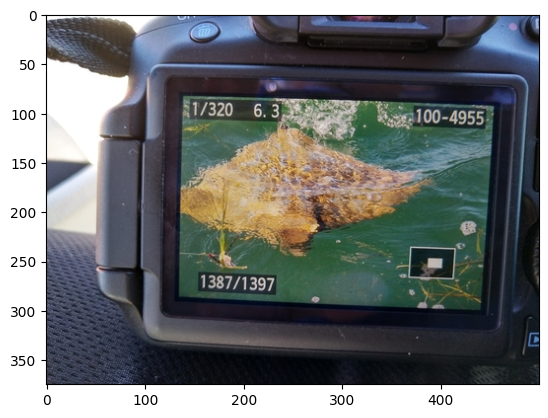

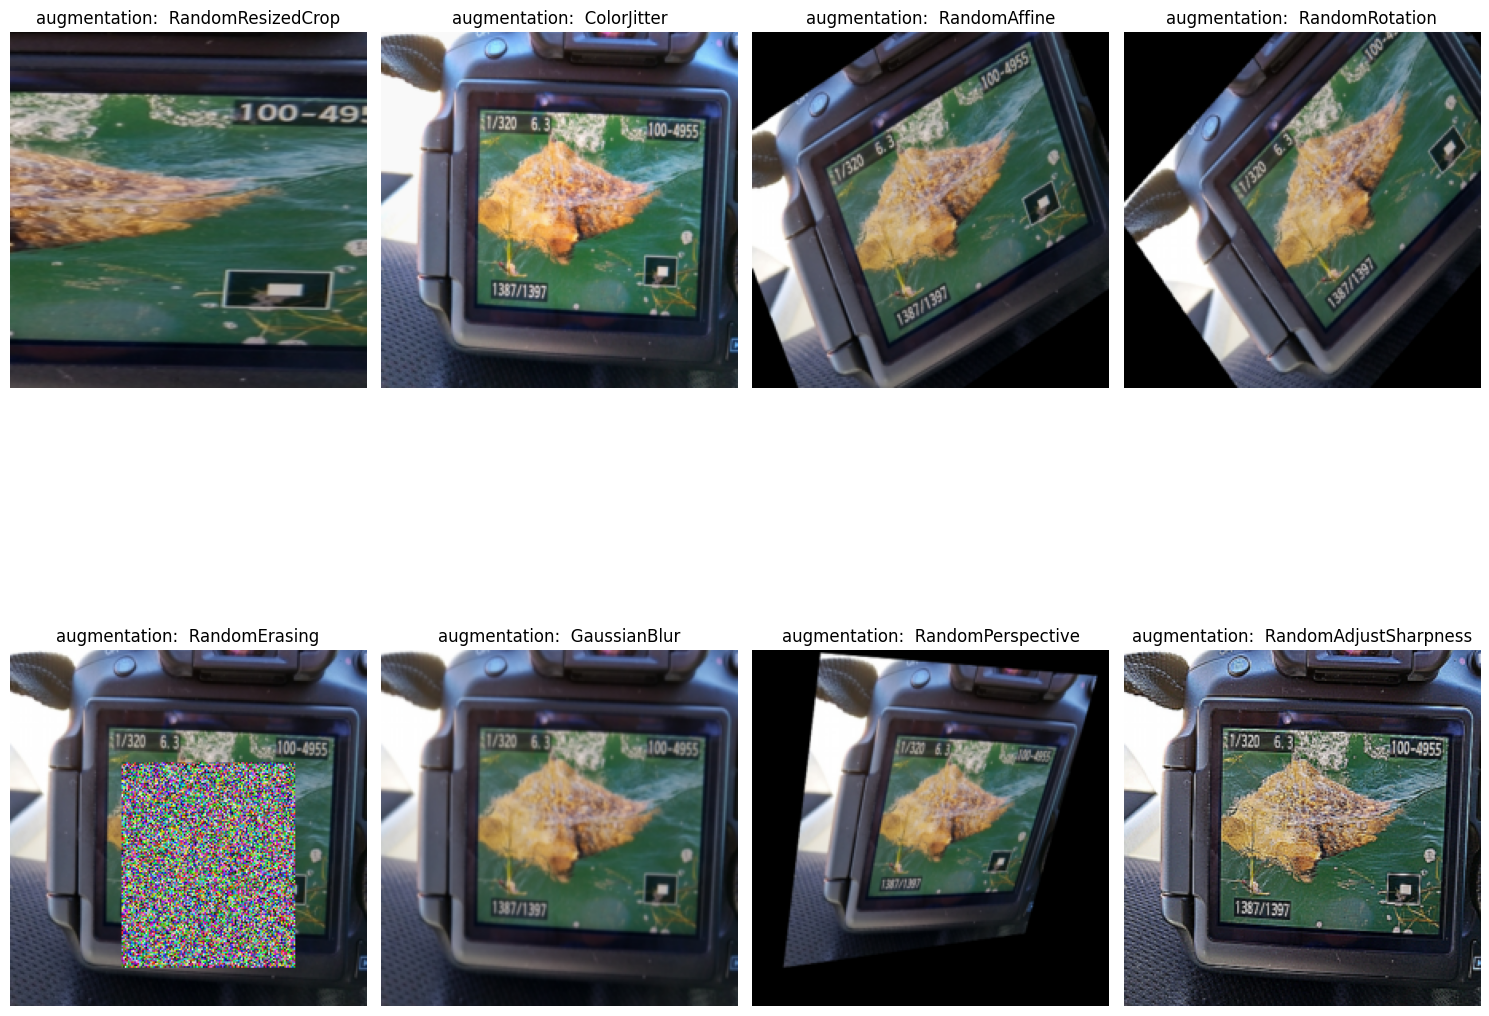

In [11]:

def show_tensor_image(image_tensor, label = ""):
    """
    Visualize a PyTorch tensor image.
    Args:
    image_tensor (torch.Tensor): A tensor of shape (C, H, W) or (1, C, H, W)
    """
    if image_tensor.dim() == 4:
        image_tensor = image_tensor.squeeze(0)  # Remove batch dimension if present

    # Convert the tensor image to numpy
    image = image_tensor.cpu().numpy().transpose(1, 2, 0)  # Reorder dimensions to (H, W, C)

    # Normalize to [0,1] if necessary
    if image.min() < 0 or image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())

    plt.imshow(image)
    plt.title(label)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

#creating a dataset from the imagenet-A images
Imagenet_A_dataset = dset.ImageFolder(root="/kaggle/input/natural-adversarial-examples-imageneta/imagenet-a/imagenet-a")
image, label = Imagenet_A_dataset[0]

# plotting base image
plt.imshow(image)


# Plotting augmentations from list
fig, axs = plt.subplots(2, 4, figsize=(15, 15))
for i, ax in enumerate(axs.flatten()):


    augmented_img = toPIL(resize(_augmentations[i](toTensor(image))))
    ax.imshow(augmented_img)
    ax.set_title(f"augmentation:  {_aug_str[i]}")
    ax.axis('off')  # Hide axis

plt.tight_layout()
plt.show()

#plt.imshow(image)

#show_tensor_image(augmix(image))

### Loss function
The marginal_entropy loss function calculates the entropy for the mean probability of the augmentations. Will be described in more detail in the MEMO section.

### Prediction Class
Class prediction is made given the previously encoded text vectors, forward pass is done on a single given image and a class is assigned based on the similarity.
The class_prediction method also computes necessary items for confidence selection: margin between two highest probabilities, max probability and the entropy of the given image

### Confidence Selection Strategy
Confidence Selection Strategy is added as an inspiration from TPT which is an augmentation selection method.
The basic premise is of these confidence selection methods is to account for the augmentations that the model is more certain of or in other words we only value the confident predictions thus the augmentations that invoke them.

Given n augmentations as input, 3 different strategies can be employed for confidence selection:
- entropy selection ranks from lowest entropy to highest, best k augmentations are selected
- confidence selection ranks the probability of the highest probability element from highest to lowest, best k augmentations are selected
- margin selection ranks the difference between two highest probabilities from highest to lowest, best k augmentations are selected

In [12]:
def marginal_entropy(logits):
    """Gets logits as input, calculates softmax probabilities,
        the mean probability and the entropy of the mean probability
    Args:
        logits: logits corresponding to different images
        likelihood of being classified as a label in the text_features_200

    Returns:
        entropy: the calculated entropy of the mean_probs
        mean_probs: the mean of distributions of images correspondence to labels
    """

    probs = logits.softmax(dim=-1)
    mean_probs = torch.mean(probs, dim=0)
    entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=-1)
    return entropy, mean_probs


def predict_class(model, image_input, text_features):

    """predicts the class for a given image within the given text_features
    Args:
        model: the clip model
        image_input: image we want to classify
        text_features: encoded vectors of the classes
    Returns:
        probs: the probability distribution given the image
        max_index: the highest probability class index
        loss: the marginal entropy loss for that one image
        diff: the margin between the highest two probabilities
    """

    #image_input = torch.tensor(np.stack(image)).to(device)

    with torch.no_grad():

        image_features = model.encode_image(image_input).float()
        #print(image_features[0][0])
        image_features /= image_features.norm(dim=-1, keepdim=True)

    logits = 100*image_features @ text_features.T
    probs = (logits).softmax(dim=-1)
    loss = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
    #loss = marginal_entropy(logits)

    loss, _ = marginal_entropy(logits)
    #print(f"prediction loss: {loss}")

    probs = probs.squeeze()
    ind = sorted(range(len(probs)), key=lambda i: probs[i], reverse=True)[:2]
    #print(ind)
    diff = abs(probs[ind[0]] - probs[ind[1]])


    return probs, probs.argmax(), loss, diff


def confidence_selection(model, text_features, augmented_images, k, select = "entropy"):

    """performs selection of given augmentations based on given confidence strategy
    Args:
        model: the clip model
        text_features: encoded vectors of the classes
        augmented_images: the images we need to choose from
        k: the number of selection
        select: type of selection (entropy, confidence, margin)
    Returns:
        top_k_augmented_images: the best images selected by the criterion
    """

    entropy = []
    confidence = []
    margin = []

    for aug in augmented_images:

        aug = aug.unsqueeze(0)
        probs, _max_prob, _entropy, _diff = predict_class(model, aug, text_features)
        entropy.append(_entropy)
        confidence.append(probs[_max_prob])
        margin.append(_diff)

        #print(loss)

    #ranking performed  depending on the choice
    if (select == "entropy"):
        top_k_indexes = sorted(range(len(entropy)), key=lambda i: entropy[i], reverse=False)[:k]
    elif (select == "confidence"):
        top_k_indexes = sorted(range(len(entropy)), key=lambda i: confidence[i], reverse=True)[:k]
    elif (select == "margin"):
        top_k_indexes = sorted(range(len(margin)), key=lambda i: margin[i], reverse=True)[:k]


    top_k_augmented_images = [augmented_images[i] for i in top_k_indexes]

    return top_k_augmented_images

### Preparation of the DATASET
Preparing the IMAGENET-A dataset which includes 7500 examples of 200 classes. The below dataset class takes in an augmentation as an argument and provides the augmentation followed by preprocessing step (for the CLIP model) during the sampling process. The confidence selection strategy is also applied at this time.

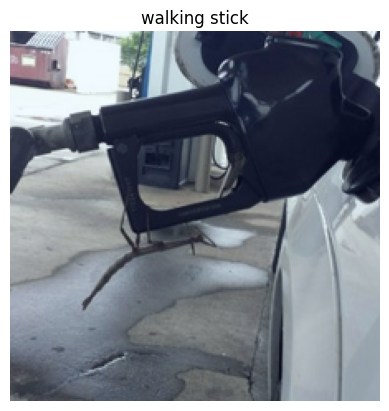

torch.Size([1, 5, 3, 224, 224])


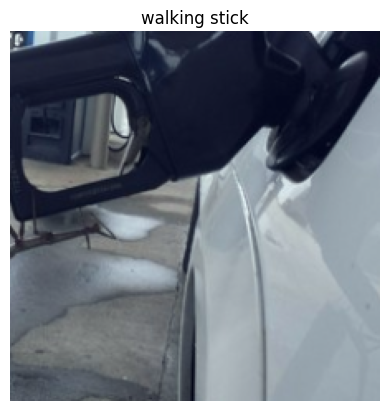

In [13]:
# Define augmentations (apply augmentations before preprocessing)
augmentation_transforms = trn.Compose([
    trn.RandomResizedCrop(224)
])

class AugmentedCLIPDataset(Dataset):
    def __init__(self, dataset, preprocess, augmentations, model, text_features, num_augmentations=5, k = 0, select = "entropy"):
        self.dataset = dataset
        self.preprocess = preprocess
        self.augmentations = augmentations
        self.num_augmentations = num_augmentations
        self.model = model
        self.text_features = text_features
        self.k = k
        self.select = select

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        #print(type(image))
        augmented_images = [self.preprocess(self.augmentations(image)).to(device) for _ in range(self.num_augmentations)]

        if self.k != 0:
            augmented_images = confidence_selection(self.model, self.text_features, augmented_images, self.k, self.select)

        return self.preprocess(image), torch.stack(augmented_images), label

set_seed(0)
Imagenet_A_dataset = dset.ImageFolder(root="/kaggle/input/natural-adversarial-examples-imageneta/imagenet-a/imagenet-a")
aug_dataset = AugmentedCLIPDataset(Imagenet_A_dataset, preprocess, augmentation_transforms, model, text_features_200, num_augmentations=5)
aug_dataloader = DataLoader(aug_dataset, batch_size=1, shuffle=True)


for image, augs, target in aug_dataloader:
    break

show_tensor_image(image, labels_200[target])
print(augs.shape)
show_tensor_image(augs[0][0], labels_200[target])

### Adapting to a single image

The below method was used for debugging purposes. Instead of tuning the model parameters on augmentations, the tuning is performed on the test image itself and the change in entropy/confidence was visualized.

In [14]:
def false_adaptation_visual(model, image, text_features, optimizer, niter=1):   #lr = 5e−5

    """tuning the given model parameters with respect to the given image (single)
    Args:
        model: the clip model
        image: given single image
        text_features: encoded vectors of the classes
        optimizer: the optimizer for the tuning process
        n_iter: number of backpropagations
    """

    for _ in range(niter):

        optimizer.zero_grad()

        image_features = model.encode_image(image).float()
        image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)

        logits = 100*image_features_norm @ text_features.T

        #print(logits.shape)

        # Normalize logits for numerical stability
        #logits = logits - logits.max(dim=-1, keepdim=True)[0]

        probs = logits.softmax(dim=-1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
        #print(f"entropy before: {entropy}")

        #loss, _ = marginal_entropy(logits)
        #a = - loss
        #print(loss)
        entropy.backward()
        optimizer.step()

        with torch.no_grad():
            image_features = model.encode_image(image).float()
            image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)

            logits = 100*image_features_norm @ text_features.T
            probs = logits.softmax(dim=-1)
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            #print(f"entropy after: {entropy}")




### MEMO

MEMO (Minimizing Entropy for a single test point) is a test-time adaptation technique aimed at improving the performance of a pre-trained model on new, unseen data. The core idea of MEMO is to adjust the model parameters during the testing phase to make it more confident in its predictions, thereby reducing prediction uncertainty. To do so, we minimize the entropy of the mean probability distribution of the augmentations. We do this instead minimizing the entropy of individual probability distributions for each augmented image since boosting the models confidence seperately for each augmentation can result in "multiple heads" boosting confidence for multiple classes which would result in less confidence for a specific item and lack the consistancy we want for the model.

- The first equation is a requirement of MEMO, a mean of the distributions that supports invariance of predictions between augmentations, so even if we do not know the true label, we know that for all augmentations, the label should be the same.

$$
\bar{p}_\theta(y|\mathbf{x}) \triangleq \mathbb{E}_{\mathbf{u}(\mathcal{A})} \left[ p_\theta(y|a(\mathbf{x})) \right] \approx \frac{1}{B} \sum_{i=1}^{B} p_\theta(y|\tilde{\mathbf{x}}_i),
$$

- The second statement of MEMO says that, model should be confident in its predictions, and thus brings us to the minimization of entropy for a prediction.
$$
\ell(\theta; \mathbf{x}) \triangleq H(\bar{p}_\theta(\cdot | \mathbf{x})) = - \sum_{y \in \mathcal{Y}} \bar{p}_\theta(y|\mathbf{x}) \log \bar{p}_\theta(y|\mathbf{x}).
$$

- Combining the two, we get the equation for MEMO, consistent augmentations coupled with a model that is more confident:
$$
\ell_{\text{CE}}(\theta; \mathbf{x}) \triangleq \frac{1}{B} \sum_{i=1}^{B} H(p_\theta(\cdot | \tilde{\mathbf{x}}_i))
$$

- Model parameter tuning (the adaptation step): We use a single backpropagation to update the model parameters by minimizing the loss function above (using AdamW optimizer with a learning rate of 5e-5).

In [15]:
def memo_adaptation_visual(model, augmentations, text_features, optimizer, niter=1):   #lr = 5e−5

    """tuning the given model parameters with respect to the augmented images
    Args:
        model: the clip model
        augmentations: given augmented images
        text_features: encoded vectors of the classes
        optimizer: the optimizer for the tuning process
        n_iter: number of backpropagations
    """
    #image_input = torch.tensor(np.stack(augmented_images)).to(device)

    #print(image.shape)
    #print(augmentations.shape)


    for _ in range(niter):

        optimizer.zero_grad()

        image_features = model.encode_image(augmentations).float()
        image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = 100*image_features_norm @ text_features.T
        probs = logits.softmax(dim=-1)

        #print(torch.sum(probs, dim = -1))
        #print(probs.shape)
        mean_probs = torch.mean(probs, dim=0)
        #print(mean_probs.shape)
        entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=-1)
        loss, _ = marginal_entropy(logits)

        #print(f"entropy: {entropy}")
        #print(f"loss: {loss}")

        entropy.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()


#         with torch.no_grad():
#             image_features = model.encode_image(augmentations).float()
#             image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)
#             logits = alpha*image_features_norm @ text_features.T
#             probs = logits.softmax(dim=-1)
#             mean_probs = torch.mean(probs, dim=0)
#             entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=-1)
#             loss, _ = marginal_entropy(logits)

#             print(f"entropy_after: {entropy}")
#             #print(f"loss_after: {loss}")

        return mean_probs


### Testing MEMO on single input

Below, you can see the model's predictions (title of the histogram) as well as the probability distribution:

- before adaptation
- after adaptation on MEMO
- different augmentations before adaptation

The image given below is an example how adaptation can sometimes lead to worse results.
Balloon is predicted when the actual label is fly.

before adaptation


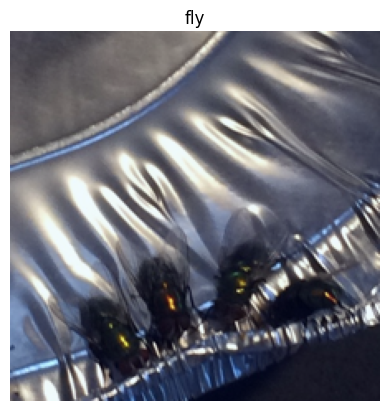

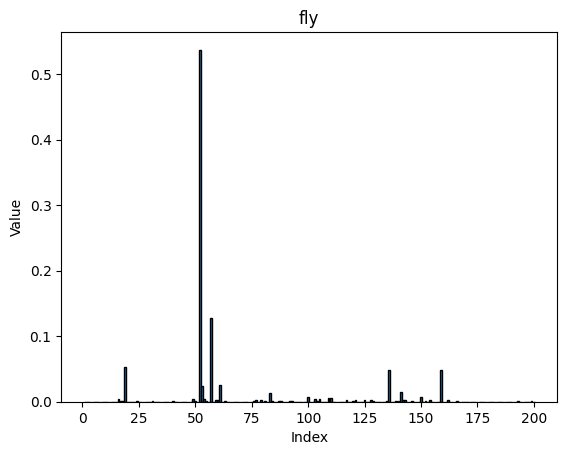

after adaptation


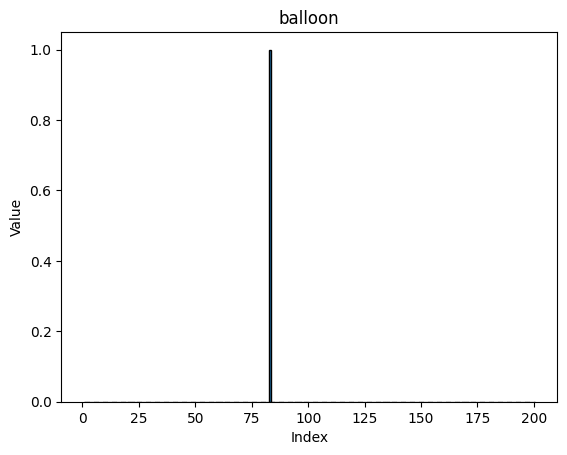

augmentations


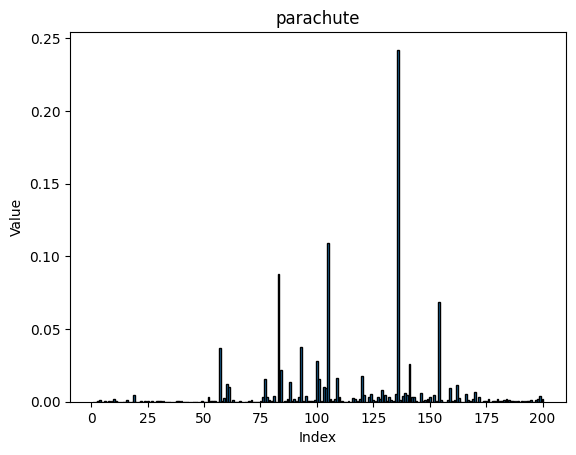

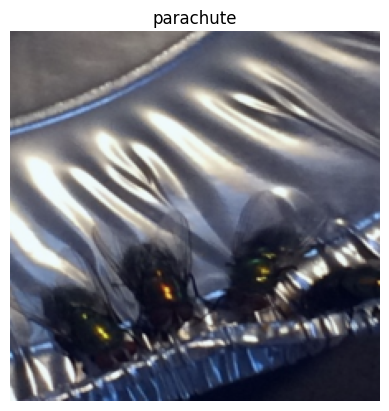

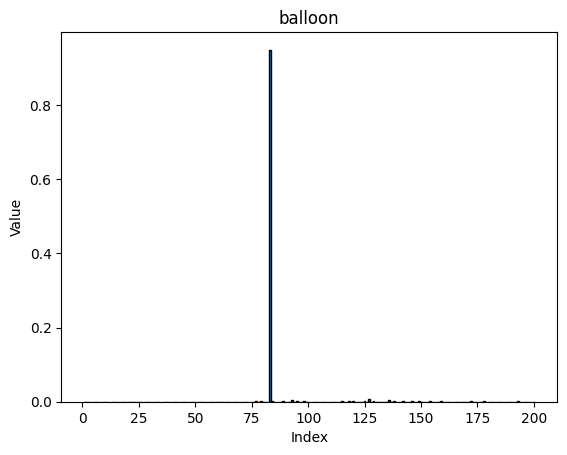

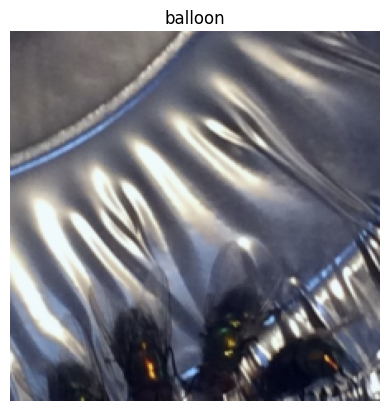

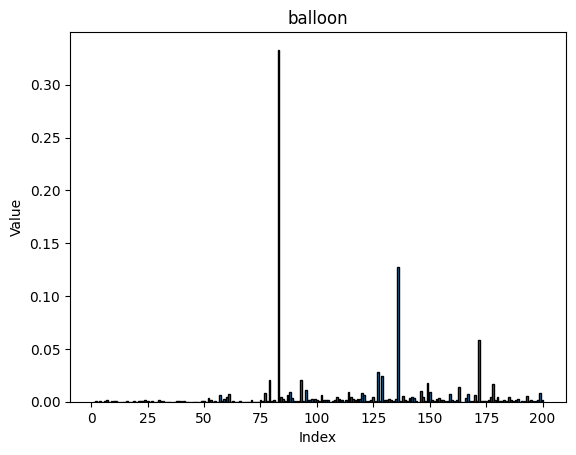

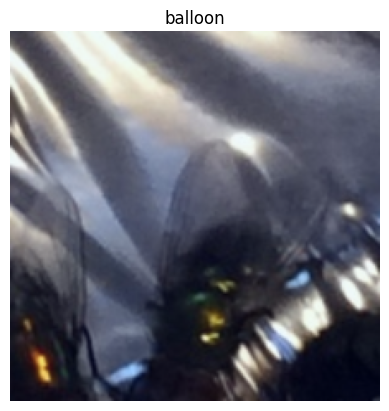

In [16]:
def hist(probs):
    """given probability it plots the histogram
    Args:
        probs: the probability distribution
    """

    probs = probs.squeeze()

    classes = list(range(1, probs.shape[0] + 1))
    plt.bar(classes, probs, edgecolor='black')
    plt.title(labels_200[probs.argmax()])
    plt.xlabel('Index')
    plt.ylabel('Value')

    plt.show()


set_seed(3)
aug_dataset = AugmentedCLIPDataset(Imagenet_A_dataset, preprocess, augmentation_transforms, model, text_features_200,
                                   num_augmentations = 3, k = 0, select = "entropy")
aug_dataloader = DataLoader(aug_dataset, batch_size=1, shuffle=True)

learning_rate = 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate)

for i, (image,augmentations,target) in enumerate(aug_dataloader):

    if(i == 0):

        augmentations = augmentations[0]
        model.load_state_dict(torch.load("initial_model_state.pth"))

        image = image.to(device)
        target = target.to(device)

        print("before adaptation")
        probs, index, loss, _ = predict_class(model, image, text_features_200)
        show_tensor_image(image, labels_200[target])
        hist(probs.cpu().numpy())
        #print(loss)

        m_probs = memo_adaptation_visual(model, augmentations, text_features_200, optimizer, niter=1)
        #false_adaptation_visual(model, image, text_features_200, optimizer, niter=1

        #hist(m_probs.detach().cpu().numpy())

        print("after adaptation")
        probs, index,loss, _ = predict_class(model, image, text_features_200)
        hist(probs.cpu().numpy())
        #print(loss)
        #print(probs)

        break


model.load_state_dict(torch.load("initial_model_state.pth"))

print("augmentations")
for augmented in augmentations:
    augmented = torch.reshape(augmented, (1, *augmented.shape))
    probs, index,loss, _ = predict_class(model, augmented, text_features_200)
    hist(probs.cpu().numpy())
    #false_adaptation_visual(model, aug, text_features_200, optimizer, niter=1)
    show_tensor_image(augmented, labels_200[index])


## RESULTS:

### PREDICTION ON BASE CLIP without MEMO:

Predictions made using predict_class method without using any augmentations or TTA.
- (Currently, only 100 samples are being tested, to replicate the full results, you can remove the until argument or set it to a value higher than 7500)

- After iterating through the entire dataset, the accuracy is found as: 45.7%
- Accuracy over first 100 images found as 0.45

In [ ]:
def run_base(aug_dataloader, model, text_features_200, until = 7499, save = True):

    """runs the base model without memo and returns the predictions
    Args:
        aug_dataloader: the dataloader
        model: the clip model
        text_features: encoded vectors of the classes
        until: number of samples to iterate through
        save: boolean var for saving the notebook link
    Returns:
        predictions: A list of class indexes for predictions
        truth: A list for ground truth indexes
    """

    correct = 0
    predictions = []
    truth = []


    for i, (image,augmentations,target) in enumerate(tqdm(aug_dataloader, desc="Training Progress", total=len(aug_dataloader))):

        model.load_state_dict(torch.load("initial_model_state.pth"))

        image = image.to(device)
        target = target.to(device)

        probs, index, loss, _ = predict_class(model, image, text_features_200)

        #print(f"Top prediction: {labels_200[index]}")
        #print(f"Ground truth: {labels_200[target]}")

        if(index == target):
            correct = correct + 1

        predictions.append(int(index))
        truth.append(int(target))


        if(i == until):
            break


    acc = correct/(until+1)

    print(correct)
    print(acc)

    if(save):
        file_path = '/kaggle/working/predictions.txt'

        with open(file_path, 'w') as file:
            for ind in predictions:
                file.write("%d\n" % ind)


        file_path = '/kaggle/working/truth.txt'

        with open(file_path, 'w') as file:
            for ind in truth:
                file.write("%d\n" % ind)

    return predictions, truth



set_seed(3)
model.load_state_dict(torch.load("initial_model_state.pth"))
aug_dataset = AugmentedCLIPDataset(Imagenet_A_dataset, preprocess, augmentation_transforms, model, text_features_200, num_augmentations = 1, k = 0)
aug_dataloader = DataLoader(aug_dataset, batch_size=1, shuffle=True)
predictions, truth = run_base(aug_dataloader, model, text_features_200, until = 99, save = False)

Training Progress:   1%|          | 84/7500 [01:31<4:13:05,  2.05s/it]

### TESTING FULL DATASET ON AUGMENTATIONS:

Using RandomResizedCrops on the full dataset:

- (Currently, only 100 samples are being tested, to replicate the full results, you can remove the until argument or set it to a value higher than 7500)

- 4086 correct classifications over 7500 with an accuracy of 54.48%

In [ ]:

def run_memo(aug_dataloader, model, text_features_200, optimizer, until = 7499, save = True):

    """runs the model with memo and returns the predictions
    Args:
        aug_dataloader: the dataloader
        model: the clip model
        text_features: encoded vectors of the classes
        until: number of samples to iterate through
        save: boolean var for saving the notebook link
    Returns:
        predictions_m: A list of class indexes for predictions
    """

    correct = 0
    predictions_m = []

    for i, (image,augmentations,target) in enumerate(tqdm(aug_dataloader, desc="Training Progress", total=len(aug_dataloader))):

        model.load_state_dict(torch.load("initial_model_state.pth"))

        augmentations = augmentations[0]

        image = image.to(device)
        target = target.to(device)

        memo_adaptation_visual(model, augmentations, text_features_200, optimizer, niter = 1)
        probs, index, loss, _ = predict_class(model, image, text_features_200)

        #print(f"Top prediction: {labels_200[index]}")
        #print(f"Ground truth: {labels_200[target]}")

        if(index == target):
            correct = correct + 1

        predictions_m.append(int(index))

        if(i == until):
            break

    #print(predictions_m)
    acc = correct/(until+1)
    print(correct)
    print(acc)


    if(save):
        file_path = '/kaggle/working/predictions_memo.txt'

        with open(file_path, 'w') as file:
            for ind in predictions_m:
                file.write("%d\n" % ind)

        print(f"File saved at {file_path}")

    return predictions_m


set_seed(3)
model.load_state_dict(torch.load("initial_model_state.pth"))
aug_dataset = AugmentedCLIPDataset(Imagenet_A_dataset, preprocess, augmentation_transforms, model, text_features_200,
                                   num_augmentations = 20, k = 5, select = "confidence")
aug_dataloader = DataLoader(aug_dataset, batch_size=1, shuffle=True)
learning_rate = 5e-5 #5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate)

predictions_m = run_memo(aug_dataloader, model, text_features_200, optimizer, until = 99, save = False)


### Confusion Matrices:

In [ ]:
num_classes = 200

# Compute confusion matrix
cm = confusion_matrix(truth, predictions, labels=np.arange(num_classes))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust figure size
cax = ax.matshow(cm, cmap=plt.cm.Blues)

# Add colorbar
plt.colorbar(cax)

# Set axis labels and title
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16)

# Rotate the tick labels for better readability
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.xaxis.set_ticks_position('bottom')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# Display the plot
plt.show()


# Compute confusion matrix
cm = confusion_matrix(truth, predictions_m, labels=np.arange(num_classes))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust figure size
cax = ax.matshow(cm, cmap=plt.cm.Blues)

# Add colorbar
plt.colorbar(cax)

# Set axis labels and title
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Confusion Matrix(MEMO)', fontsize=16)

# Rotate the tick labels for better readability
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.xaxis.set_ticks_position('bottom')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# Display the plot
plt.show()

### Testing the first 100 elements in the Dataset for further improvement:

For this part, 100 images were sampled from the shuffled dataset and 20 augmentations with k = 5, all 3 confidence selection methods were tested with the 8 chosen augmentations seperately. The base model performed with an accuracy of 0.45 within these 100 samples. As a results we have the two tables below, the best result was a combination of RandomResizedCrops (RRC) and the margin selection which ranks based on the magnitude of difference between two highest probabilities with an accuracy of 0.56.

### Table 1:
This table shows the combination of augmentation with the confidence selection strategy.


<style>
table {
  width: 100%;
  border-collapse: collapse;
}

table, th, td {
  border: 1px solid black;
}

th, td {
  padding: 10px;
  text-align: left;
}

th {
  background-color: #f2f2f2;
}
</style>


<div style="text-align: left;">
<table>
  <tr>
    <th>Augmentation</th>
    <th>Entropy</th>
    <th>Confidence</th>
    <th>Margin</th>
  </tr>
  <tr>
    <td>Random Resized Crop</td>
    <td>0.55</td>
    <td>0.56</td>
    <td>0.56</td>
  </tr>
  <tr>
    <td>ColorJitter</td>
    <td>0.44</td>
    <td>0.44</td>
    <td>0.44</td>
  </tr>
  <tr>
    <td>RandomRotation</td>
    <td>0.47</td>
    <td>0.45</td>
    <td>0.46</td>
  </tr>
  <tr>
    <td>RandomAffine</td>
    <td>0.48</td>
    <td>0.44</td>
    <td>0.44</td>
  </tr>
  <tr>
    <td>RandomErasing</td>
    <td>0.34</td>
    <td>0.34</td>
    <td>0.34</td>
  </tr>
  <tr>
    <td>GaussianBlur</td>
    <td>0.46</td>
    <td>0.43</td>
    <td>0.45</td>
  </tr>
  <tr>
    <td>RandomPerspective</td>
    <td>0.42</td>
    <td>0.43</td>
    <td>0.43</td>
  </tr>
  <tr>
    <td>RandomAdjustSharpness</td>
    <td>0.44</td>
    <td>0.44</td>
    <td>0.44</td>
  </tr>
</table>
</div>


### Table 2:
This table shows the combination of Random Resized Crops(RRC) followed by an augmentation with the confidence selection strategy. This method was used because RRC produced the best results on its own and another augmentation coupled with it could reveal more of the image but unfortunately this was not the case.


<style>
table {
  width: 100%;
  border-collapse: collapse;
}

table, th, td {
  border: 1px solid black;
}

th, td {
  padding: 10px;
  text-align: left;
}

th {
  background-color: #f2f2f2;
}
</style>

<table>
  <tr>
    <th>RRC + Augmentation</th>
    <th>Entropy</th>
    <th>Confidence</th>
    <th>Margin</th>
  </tr>
  <tr>
    <td>Random Resized Crop</td>
    <td>0.50</td>
    <td>0.52</td>
    <td>0.50</td>
  </tr>
  <tr>
    <td>ColorJitter</td>
    <td>0.50</td>
    <td>0.52</td>
    <td>0.52</td>
  </tr>
  <tr>
    <td>RandomRotation</td>
    <td>0.46</td>
    <td>0.41</td>
    <td>0.45</td>
  </tr>
  <tr>
    <td>RandomAffine</td>
    <td>0.46</td>
    <td>0.41</td>
    <td>0.45</td>
  </tr>
  <tr>
    <td>RandomErasing</td>
    <td>0.47</td>
    <td>0.37</td>
    <td>0.40</td>
  </tr>
  <tr>
    <td>GaussianBlur</td>
    <td>0.46</td>
    <td>0.49</td>
    <td>0.48</td>
  </tr>
  <tr>
    <td>RandomPerspective</td>
    <td>0.51</td>
    <td>0.48</td>
    <td>0.45</td>
  </tr>
  <tr>
    <td>RandomAdjustSharpness</td>
    <td>0.48</td>
    <td>0.48</td>
    <td>0.45</td>
  </tr>
</table>


The experimentation that formed the tables was made by adjusting the below code block.

In [ ]:
# Plotting augmentations from list
for i in range(len(_augmentations)):

    augmentation_transforms = trn.Compose([
        trn.ToTensor(),
        #RandomResizedCrop(size=(224, 224), scale=(0.05, 1.0), ratio=(0.5, 2.0), interpolation=bilinear, antialias=warn),
        _augmentations[i],
        trn.Resize((224, 224)),
        trnF.to_pil_image
    ])

    print(_augmentations[i])

    set_seed(3)
    model.load_state_dict(torch.load("initial_model_state.pth"))
    aug_dataset = AugmentedCLIPDataset(Imagenet_A_dataset, preprocess, augmentation_transforms, model, text_features_200,
                                       num_augmentations = 20, k = 5, select = "entropy")
    aug_dataloader = DataLoader(aug_dataset, batch_size=1, shuffle=True)
    learning_rate = 5e-5 #5e-5
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate)

    predictions_m = run_memo(aug_dataloader, model, text_features_200, optimizer, until = 99, save = False)




### Conclusion:

To conclude, following foot steps of MEMO, we were able to reach good results. A significant increase of around 10% was seen in the top 1 accuracy from 45.7% to 54.5%. MEMO can be applied to a wide variety of pre-trained model architectures without altering the training process. Unlike other TTA methods, MEMO adapts using single test inputs, not requiring multiple test points. In tests on different augmentations we saw that MEMO consistently improves performance and achieves good results in this single test point setting.

